In [1]:
import org.apache.spark.graphx._
import org.apache.spark.rdd.RDD

val vertexArray = Array(
  (1L, ("Alice", 28)),
  (2L, ("Bob", 27)),
  (3L, ("Charlie", 65)),
  (4L, ("David", 42)),
  (5L, ("Ed", 55)),
  (6L, ("Fran", 50))
)
val edgeArray = Array(
  Edge(2L, 1L, 7),
  Edge(1L, 2L, 13),
  Edge(2L, 4L, 2),
  Edge(3L, 2L, 4),
  Edge(3L, 6L, 3),
  Edge(4L, 1L, 1),
  Edge(5L, 2L, 2),
  Edge(5L, 3L, 8),
  Edge(5L, 6L, 3)
  )

val vertexRDD: RDD[(Long, (String, Int))] = sc.parallelize(vertexArray)
val edgeRDD: RDD[Edge[Int]] = sc.parallelize(edgeArray)

val graph: Graph[(String, Int), Int] = Graph(vertexRDD, edgeRDD)

Intitializing Scala interpreter ...

Spark Web UI available at http://ziyangs-mbp.attlocal.net:4041
SparkContext available as 'sc' (version = 2.4.6, master = local[*], app id = local-1596064427898)
SparkSession available as 'spark'


import org.apache.spark.graphx._
import org.apache.spark.rdd.RDD
vertexArray: Array[(Long, (String, Int))] = Array((1,(Alice,28)), (2,(Bob,27)), (3,(Charlie,65)), (4,(David,42)), (5,(Ed,55)), (6,(Fran,50)))
edgeArray: Array[org.apache.spark.graphx.Edge[Int]] = Array(Edge(2,1,7), Edge(1,2,13), Edge(2,4,2), Edge(3,2,4), Edge(3,6,3), Edge(4,1,1), Edge(5,2,2), Edge(5,3,8), Edge(5,6,3))
vertexRDD: org.apache.spark.rdd.RDD[(Long, (String, Int))] = ParallelCollectionRDD[0] at parallelize at <console>:48
edgeRDD: org.apache.spark.rdd.RDD[org.apache.spark.graphx.Edge[Int]] = ParallelCollectionRDD[1] at parallelize at <console>:49
graph: org.apache.spark.graphx.Graph[(String, Int),Int] = org.apache.spark.graphx.impl.GraphImpl@3dfa84d6


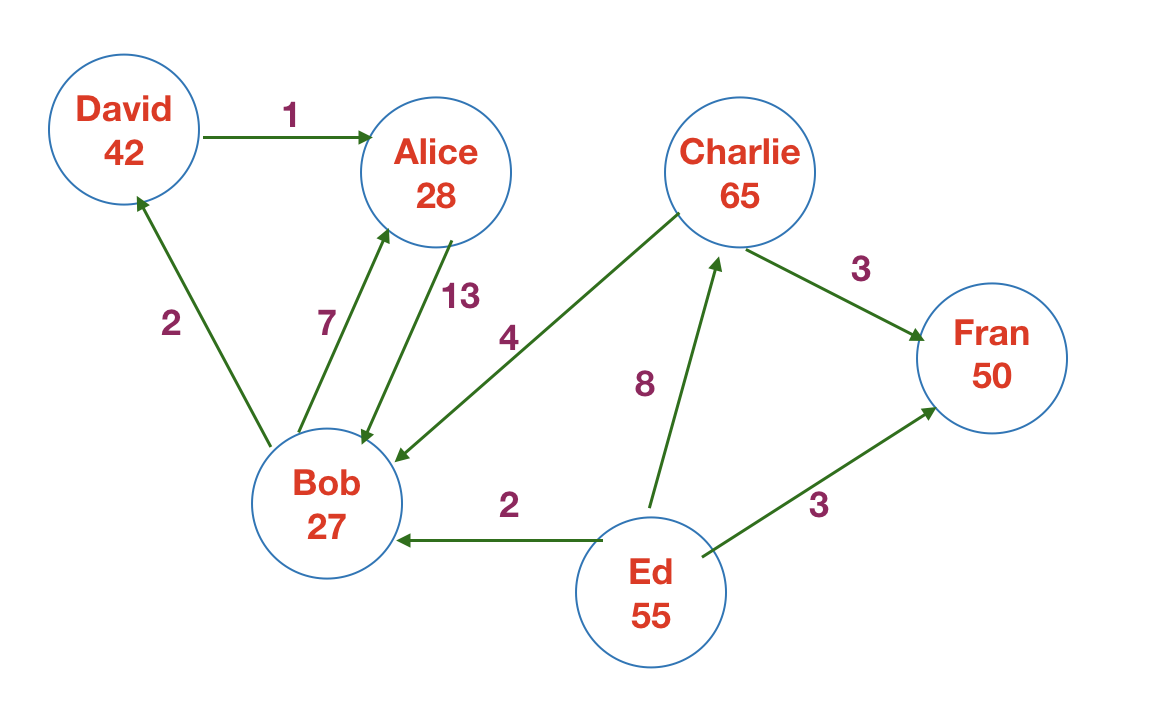

In [2]:
%%python
import matplotlib
matplotlib.use("agg")
from IPython.display import Image
with open("social_graph.png") as fo:
    retval = Image(filename=fo.name)

<h1>Triangle count</h1>
<li>reports the number of triangles a vertex belongs to</li>
<li>A triangle at vertex i is formed if a pair of adjacent nodes, j,k, are connected</li>
<li>Example, at Alice (vertex 1) there is one triangle (Alice, Bob, David)</li>
<li>At Bob (node 2) there are two triangles (Alice, Bob, David) and (Charlie, Bob, Ed)</li>
<li><span style="color:blue">triangleCount</span> returns a graph object with the same set of edges and vertices as the original graph but with vertex properties replaced with the count of triangles</li>

In [3]:
val triangles = graph.triangleCount()
triangles.vertices.collect

triangles: org.apache.spark.graphx.Graph[Int,Int] = org.apache.spark.graphx.impl.GraphImpl@7b0212ee
res0: Array[(org.apache.spark.graphx.VertexId, Int)] = Array((4,1), (1,1), (5,2), (6,1), (2,2), (3,2))


<h1>Clustering coefficients</h1>
<li>If a vertex has n neighbors, then the number of possible triangles it belongs to is given by $n \choose 2$</li>
<li>To get the number of actual triangles, first convert the graph to one with canonical edges (i.e., only one edge between each pair of vertices</li>
<li><span style="color:blue">convertToCanonicalEdges</span> does this by iterating through the vertices and picking the first edge between it and its neighbors</li>
<li><span style="color:blue">degrees</span> will give us the number of neighbors and we can use this to calculate the number of possible triangles</li>

In [4]:
val possible_triangles = graph.convertToCanonicalEdges().degrees.map(d => (d._1,d._2*(d._2-1)/2))
possible_triangles.collect

possible_triangles: org.apache.spark.rdd.RDD[(org.apache.spark.graphx.VertexId, Int)] = MapPartitionsRDD[84] at map at <console>:30
res1: Array[(org.apache.spark.graphx.VertexId, Int)] = Array((4,1), (1,1), (5,3), (6,1), (2,6), (3,3))


<li>We now have the actual triangles and the possible triangles</li>
<li>dividing actual by possible will give us the clustering co-efficient</li>
<li>first we'll zip the actuals and the possibles</li>
<li>and then do the division</li>


In [5]:
val actual_triangles = triangles.vertices
val triangles_and_degrees = (actual_triangles zip possible_triangles)
val clustering_coefficients = triangles_and_degrees.map(p => (p._1._1,p._1._2.toDouble/p._2._2))


clustering_coefficients.foreach(l=>println("Vertex: "+l._1+ " Coefficient: "+l._2))

Vertex: 1 Coefficient: 1.0
Vertex: 3 Coefficient: 0.6666666666666666
Vertex: 6 Coefficient: 1.0
Vertex: 4 Coefficient: 1.0
Vertex: 5 Coefficient: 0.6666666666666666
Vertex: 2 Coefficient: 0.3333333333333333


actual_triangles: org.apache.spark.graphx.VertexRDD[Int] = VertexRDDImpl[63] at RDD at VertexRDD.scala:57
triangles_and_degrees: org.apache.spark.rdd.RDD[((org.apache.spark.graphx.VertexId, Int), (org.apache.spark.graphx.VertexId, Int))] = ZippedPartitionsRDD2[85] at zip at <console>:33
clustering_coefficients: org.apache.spark.rdd.RDD[(org.apache.spark.graphx.VertexId, Double)] = MapPartitionsRDD[86] at map at <console>:34
